# Actin - Classification

In [64]:
import json
import numpy

from collections import defaultdict
from matplotlib import pyplot

MODELS = {
    "scratch" : [
        "20240220-162652_46_cb54d5d4",
        "20240220-162652_45_bcf2ba73",
        "20240220-162652_44_3d1583db",
        "20240220-161821_43_6701d90e",
        "20240220-161821_42_6a3dc706",
    ],
    "ssl" : [
        "20240220-161407_45_32e9a2c2",
        "20240220-161407_44_8e46dd3b",
        "20240220-161407_42_e5b104d5",
        "20240220-161358_46_82caa22a",
        "20240220-161358_43_ece784df", 
    ],
    "ssl+freeze" : [
        "20240220-161821_45_47a116c3",
        "20240220-161814_46_122296a6",
        "20240220-161407_44_7c501f3f",
        "20240220-161407_43_90a646eb",
        "20240220-161358_42_fd3abfbe",
    ]
}

out = defaultdict(list)
for condition, model_names in MODELS.items():
    for model_name in model_names:
        data = json.load(open(f"/home-local/Multilabel-Proteins-Actin/Segmentation/{model_name}/predictions.json", "r"))
        keys = sorted(data.keys(), key=lambda key : int(key))

        total_truth, total_pred = [], []
        for key in keys:
            total_truth.extend(data[key][0]), total_pred.extend(data[key][1])

        total_truth, total_pred = numpy.array(total_truth), numpy.array(total_pred)

        accuracy = numpy.sum(total_truth == total_pred, axis=0) / len(total_truth)
        out[condition].append(accuracy)
    

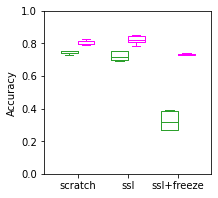

KruskalResult(statistic=25.001916648094504, pvalue=0.0001392151113138212)
0 0 MannwhitneyuResult(statistic=12.5, pvalue=1.0)
0 1 MannwhitneyuResult(statistic=0.0, pvalue=0.0119252335930176)
0 2 MannwhitneyuResult(statistic=17.5, pvalue=0.34426654809108104)
0 3 MannwhitneyuResult(statistic=0.0, pvalue=0.0119252335930176)
0 4 MannwhitneyuResult(statistic=25.0, pvalue=0.011667312343319386)
0 5 MannwhitneyuResult(statistic=20.5, pvalue=0.11049202405566802)
1 1 MannwhitneyuResult(statistic=12.5, pvalue=1.0)
1 2 MannwhitneyuResult(statistic=25.0, pvalue=0.007936507936507936)
1 3 MannwhitneyuResult(statistic=8.0, pvalue=0.42063492063492064)
1 4 MannwhitneyuResult(statistic=25.0, pvalue=0.0119252335930176)
1 5 MannwhitneyuResult(statistic=25.0, pvalue=0.0119252335930176)
2 2 MannwhitneyuResult(statistic=12.5, pvalue=1.0)
2 3 MannwhitneyuResult(statistic=0.0, pvalue=0.007936507936507936)
2 4 MannwhitneyuResult(statistic=25.0, pvalue=0.0119252335930176)
2 5 MannwhitneyuResult(statistic=10.0, pva

In [118]:
COLORS = {"rings" : "tab:green", "fibers" : "magenta", 0 : "tab:green", 1 : "magenta"}
fig, ax = pyplot.subplots(figsize=(3,3))
samples = []
for i, (key, values) in enumerate(out.items()):
    values = numpy.array(values)
    widths = 1 / (values.shape[-1] + 1)
    for n in range(values.shape[-1]):
        bplot = ax.boxplot(values[:, n], positions=[i + n * widths], widths=widths)
        samples.append(values[:, n])
        for key, parts in bplot.items():
            for part in parts:
                part.set_color(COLORS[n])
    ax.set(
        xticks=numpy.arange(len(out)) + widths / values.shape[-1],
        xticklabels=out.keys(),
        ylabel="Accuracy", ylim=(0, 1)
    )
pyplot.show()

from scipy import stats
print(stats.kruskal(*samples))
for i in range(len(samples) - 1):
    for j in range(i, len(samples)):
        print(i, j, stats.mannwhitneyu(samples[i], samples[j]))


# Actin - Segmentation

In [66]:
# Imports 
from tqdm.auto import tqdm
import itertools
import random
import scikit_posthocs
import pandas
import h5py
import tifffile

random.seed(42)
numpy.random.seed(42)

import numpy
import glob
import os
import itertools

from skimage import measure
from matplotlib import pyplot
from collections import defaultdict
from scipy import stats

import statistics
# user-defined package
from metrics import SBD

def get_files(path, keys):
    """
    Gets the files from the given path
    """
    def order(l):
        return sorted(l, key=lambda item : int(item.split(os.path.sep)[-1].split("_")[1].split("-")[0]))
    files = {}
    for key in keys:
        files[key] = order(glob.glob(os.path.join(path, "{}_*.tif".format(key))))
    return files

def iou_score(truth, predicted, foreground):
    """
    Computes the intersection over union of the data

    :param truth: The ground truth to predict
    :param predicted: Predictions from the network
    :param foreground: Foreground dectection

    :returns : The intersection over union between the ground truth and predictions
    """
    truth, predicted, foreground = truth.astype(bool), predicted.astype(bool), foreground.astype(bool)
    intersection = truth * predicted
    union = truth + predicted
    return intersection[foreground].sum() / (union[foreground].sum() + 1)

def confusion_matrix(truth, predicted, foreground):
    """
    Computes the confusion matrix of the data

    :param truth: Ground truth to predict
    :param predicted: Predictions from the network
    :param foreground: Foreground detections

    :returns : The confusion matrix from the ground truth and predictions
    """
    truth, predicted, foreground = truth.astype(bool), predicted.astype(bool), foreground.astype(bool)

    true_neg = (~truth * ~predicted)[foreground].sum()
    true_pos = (truth * predicted)[foreground].sum()
    false_neg = (truth * ~predicted)[foreground].sum()
    false_pos = (~truth * predicted)[foreground].sum()

    cm = numpy.array([[true_neg, false_pos], [false_neg, true_pos]])
    return cm

def f1_score(cm):
    """
    Calcultes the f1 score from the confusion matrix
    :param cm: confusion matrix
    :returns : The f1 score
    """
    return (2 * cm[1, 1]) / (cm[0, 1] + 2 * cm[1, 1] + cm[1, 0])

def intensity_dist(image, mask, foreground):
    """
    Retreives the intensity distribution under the mask from the image

    :param image: A 2D `numpy.ndarray`
    :param mask: A 2D `numpy.ndarray` of foreground

    :returns : An histogram of intensity
    """
    mask, foreground = mask.astype(bool), foreground.astype(bool)
    return numpy.histogram(image[mask & foreground], bins=int(0.15 * (0.8 * 574.3676843134317)), range=(0, 0.15))

def fft_ratio(image, truth, predicted, foreground):
    """
    Computes the cross correlation between the pixels in the ground truth mask
    and the pixels in the predicted mask

    :param image: A 2D `numpy.ndarray` of the image
    :param truth: A 2D `numpy.ndarray` of the ground truth mask
    :param predicted: A 2D `numpy.ndarray` of the predicted mask
    :param foreground: A 2D `numpy.ndarray` of the detected foreground

    :returns : The cross correlation after shuffle
    """
    truth, predicted, foreground = map(lambda ary : ary.astype(bool), (truth, predicted, foreground))
    ary_1, ary_2 = image * truth * foreground, image * predicted * foreground

    fft_orig, freq = fft(image, numpy.ones(image.shape))
    fft_truth, freq = fft(ary_1.reshape(image.shape), numpy.ones(image.shape))
    fft_pred, freq = fft(ary_2.reshape(image.shape), numpy.ones(image.shape))

    # Creates a mesh grid of angles
    yy, xx = numpy.meshgrid(*freq)
    xx[(xx == 0)] += 1 # Avoids 0 division
    atan = numpy.arctan(yy / xx) * 180 / numpy.pi + 90
    atan[xx >= 0] += 180

    forig, ftruth, fpred = [], [], []
    angles, wavelengths = numpy.arange(0, 360, 10), numpy.arange(170, 200, 10)
    for angle in angles:
        for wavelength in wavelengths:
            z = (xx**2 + yy**2 <= (1 / wavelength)**2) & (xx**2 + yy**2 >= (1 / (wavelength + 10))**2) & \
                (atan >= angle) & (atan <= angle + 10)
            forig.append(fft_orig[z].sum())
            ftruth.append(fft_truth[z].sum())
            fpred.append(fft_pred[z].sum())

    forig, ftruth, fpred = map(lambda l : numpy.array(l).reshape(len(angles), len(wavelengths)), (forig, ftruth, fpred))

    ratio_truth = (ftruth.sum() - forig.sum()) / fft_orig.sum()
    ratio_pred = (fpred.sum() - forig.sum()) / fft_orig.sum()
    return abs(ratio_truth - ratio_pred)

def fft_shuffle(image, truth, predicted, foreground):
    """
    Computes the cross correlation between the pixels in the ground truth mask
    and the pixels in the predicted mask

    :param image: A 2D `numpy.ndarray` of the image
    :param truth: A 2D `numpy.ndarray` of the ground truth mask
    :param predicted: A 2D `numpy.ndarray` of the predicted mask
    :param foreground: A 2D `numpy.ndarray` of the detected foreground

    :returns : The cross correlation after shuffle
    """
    def shuffle(image, mask):
        """
        Shuffles the pixel values under mask
        """
        indices_orig = numpy.arange(image.size)
        indices_new = numpy.arange(image.size)

        shuffle_orig = numpy.where(mask)[0]
        shuffle_new = numpy.where(mask)[0]
        numpy.random.shuffle(shuffle_new)

        indices_new[shuffle_new] = indices_orig[shuffle_orig]
        temp_image = numpy.copy(image)
        temp_image[indices_new] = image[indices_orig]
        return temp_image
    truth, predicted, foreground = map(lambda ary : ary.astype(bool).ravel(), (truth, predicted, foreground))
    ary_1, ary_2 = shuffle(image.ravel(), truth), shuffle(image.ravel(), predicted)

    fft_orig, freq = fft(image, numpy.ones(image.shape))
    fft_truth, freq = fft(ary_1.reshape(image.shape), numpy.ones(image.shape))
    fft_pred, freq = fft(ary_2.reshape(image.shape), numpy.ones(image.shape))

    # Creates a mesh grid of angles
    yy, xx = numpy.meshgrid(*freq)
    xx[(xx == 0) & (yy == 0)] += 1 # Avoids 0 division
    atan = numpy.arctan(yy / xx) * 180 / numpy.pi + 90
    atan[xx >= 0] += 180

    forig, ftruth, fpred = [], [], []
    angles, wavelengths = numpy.arange(0, 360, 10), numpy.arange(170, 200, 10)
    for angle in angles:
        for wavelength in wavelengths:
            z = (xx**2 + yy**2 <= (1 / wavelength)**2) & (xx**2 + yy**2 >= (1 / (wavelength + 10))**2) & \
                (atan >= angle) & (atan <= angle + 10)
            forig.append(fft_orig[z].mean())
            ftruth.append(fft_truth[z].mean())
            fpred.append(fft_pred[z].mean())

    forig, ftruth, fpred = map(lambda l : numpy.array(l).reshape(len(angles), len(wavelengths)), (forig, ftruth, fpred))
    return rmse((ftruth - forig) / forig, (fpred - forig) / forig)

def fft(ary, foreground, timestamp=20):
    """
    Computes the FFT of an image

    :param ary: A 2D `numpy.ndarray`
    :param foreground: A 2D `numpy.ndarray` of the detected foreground

    :returns : Fourier transform and the frequency axis
    """
    x = numpy.fft.fft2(ary * foreground)
    return numpy.abs(x), tuple(numpy.fft.fftshift(numpy.fft.fftfreq(shape, d=timestamp)) for shape in ary.shape)

def cross_correlation(ary_1, ary_2, foreground, timestamp=20):
    """
    Computes the cross correlation between two `numpy.ndarray`

    :param ary_1: A 2D `numpy.ndarray`
    :param ary_2: A 2D `numpy.ndarray`
    :param foreground: A 2d `numpy.ndarray` of the detected foreground

    :returns : The cross correlation
    """
    x = numpy.stack((ary_1 * foreground, ary_2 * foreground), axis=0)
    x = numpy.fft.fft2(x / x.max(axis=(1, 2))[:, numpy.newaxis, numpy.newaxis])
    return numpy.abs(x[1]), tuple(numpy.fft.fftshift(numpy.fft.fftfreq(x.shape[i], d=timestamp)) for i in range(1, 3))
    # x[1] = numpy.conj(x[1]) # Conjugate for correlation
    # corr = numpy.fft.fftshift(numpy.fft.ifft2(numpy.prod(x, axis=0)))
    # corr = numpy.abs(corr)
    # return corr, tuple(numpy.fft.fftshift(numpy.fft.fftfreq(x.shape[i], d=timestamp)) for i in range(1, 3))

def rmse(ary_1, ary_2):
    """
    Computes the root mean square error between two `numpy.ndarray`

    :param ary_1: A `numpy.ndarray`
    :param ary_2: A `numpy.ndarray`

    :returns : RMSE
    """
    return numpy.sqrt(numpy.mean((ary_1 - ary_2)**2))

def scores(data):
    """
    Calculates the mean per class cross correlation scores
    """
    output = {}
    for key, values in data.items():
        output[key] = [func(values) for func in (numpy.mean, numpy.std)]
    return output

def plot_scores(scores):
    """
    Plots the scores as histograms of the metrics

    :params scores: A sequence of dict results

    NOTE. We assume dicts in the following order ; "CROSSCORR"
    """
    cmap = pyplot.cm.get_cmap("tab20")
    scores_names = ["CROSSCORR"]
    ind, widths = numpy.arange(2), 0.33
    fig, ax = pyplot.subplots(figsize=(4,3))
    print(scores)
    for i, (_scores, name) in enumerate(zip(scores, ["coarse", "precise"])):
        _s = numpy.array([_scores[key] for key in ["rings", "fibers"]])
        ax.bar(ind + (i) * widths, _s[:, 0], width=widths, yerr=_s[:, 1], color=cmap(0 if name=="coarse" else 1), label=scores_names[0] if name=="coarse" else None)
    # ax.set_ylim(0, 0.8)
    ax.set_ylabel("Metric Performance")
    # ax.set_xticks(ind + len(scores) * widths - 0.5 * widths)
    # ax.set_xticklabels(["Rings", "Fibers"])
    pyplot.legend()
    # pyplot.show()

def plot_fft(samples, conditions):
    """
    Plots the comparaison between coarse and precise

    :param samples: A `tuple` of samples
    """
    cmap = pyplot.get_cmap("tab10")
    fig, ax = pyplot.subplots(figsize=(4,5), tight_layout=True)
    ind = numpy.arange(len(samples))
    for scores in zip(*samples):
        ax.plot(ind, scores, color="gray", alpha=0.3)
        ax.scatter(ind, scores, color="gray", alpha=0.5, s=100)
    ax.plot(ind, list(map(numpy.mean, samples)), color=cmap(0), alpha=1)
    ax.scatter(ind, list(map(numpy.mean, samples)), color=cmap(0), s=100, alpha=1, zorder=3)
    ax.set_xlim(ind.min()-0.5, ind.max()+0.5)
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Metric performance")
    pyplot.savefig("/home/anthony/Desktop/rings.pdf", bbox_inches="tight", transparent=True)

def plot_hist(dicts, conditions):
    """
    Plots the given dicts of distribution

    :param dicts: A sequence of `dict` objects

    NOTE. We assume dicts to be in following order ; original, coarse, precise
    """
    for i, key in enumerate(["fibers"]):
        fig, ax = pyplot.subplots(figsize=(7,4))
        _all_hist = []
        for _dict, name in zip(dicts, conditions):
            total_hist = []
            for hist, bins in _dict[key]:
                total_hist.append(hist / numpy.sum(hist))
            bins = bins.copy() * (0.8 * 574.3676843134317)
            ax.bar(bins[:-1], numpy.mean(total_hist, axis=0), label=name,
                        width=numpy.diff(bins), align="edge", alpha=0.3)

            _all_hist.append(total_hist)
        pyplot.legend()

        ax.set_xlabel("Pixel value (counts)")
        ax.set_ylabel("Normalized frequency (-)")

        _all_hist = numpy.array(_all_hist)
        sig = []
        for samples in _all_hist.T:
            significance = statistics.get_significance(samples.T, force_normal_test=True, verbose=False)
            sig.append([s[0] for s in significance])

        print(key, sig[:5])

def plot_scores(dicts, conditions, metrics):
    """
    Plots the data contained in the given dicts

    :param dicts: A sequence of `dict` objects
    :param conditions: A `list` of condition to use in the `dict`
    :param metrics: A `list` of metrics to use in the `dict`
    """
    fig, ax = pyplot.subplots(figsize=(5, 3))
    width = 1 / ((len(metrics) * len(conditions)) + 1)
    cmap = pyplot.get_cmap("tab20c")
    for c, condition in enumerate(conditions):
        for m, metric in enumerate(metrics):
            for o, obj in enumerate(["rings", "fibers"]):
                data = dicts[condition][metric][obj]
                mean, std = numpy.mean(data), numpy.std(data)
                bar_id = (len(conditions) * m + c)
                ax.bar(o + bar_id * width, mean, yerr=std, width=width, color=cmap(bar_id % len(conditions) + m * 4),
                        label = metric if (bar_id % len(conditions) == 0) and (o == 0) else None)
    ax.set_ylabel("Metric Performance")
    ax.set_xticks(numpy.arange(2) + (len(metrics) * len(conditions) - 1) * width / 2)
    ax.set_xticklabels(["Rings", "Fibers"])
    ax.set_ylim(0, 0.8)
    ax.legend()

def contains_outliers(samples):
    """
    Uses the modified Z-Score to test for outliers

    :param samples: A numpy array of samples

    :returns : A boolean array wheter data point is not outliers

    Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and Handle Outliers", The ASQC Basic References in Quality Control: Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
    """
    med = numpy.median(samples)
    M = 0.6745 * (samples - med) / numpy.median(numpy.abs(samples - med))
    return numpy.abs(M) <= 3.5

path = "/home-local"
result_folder = "{}/Multilabel-Proteins-Actin/Segmentation/precise".format(path)
image_folder = "{}/Multilabel-Proteins-Actin/Segmentation".format(path)
keys=["rings", "fibers"]

files = get_files(result_folder, keys=keys)


In [74]:
# Compute mapping
# There was some changes in the order of files
# We compute the mapping by using the pearson correlation
mapping = {}
for filename in tqdm(glob.glob(os.path.join(image_folder, "*_image.tif"))):
    images = tifffile.imread(filename)
    mapping[os.path.basename(filename)] = {}
    for image_idx, image in enumerate(tqdm(images, leave=False)):
        current_max = -1
        optimal_mapping = None
        flag = False
        for filename_to_be_mapped in glob.glob(os.path.join(image_folder, "20240220-161821_42_6a3dc706", "*image.tif")):
            images_to_be_mapped = tifffile.imread(filename_to_be_mapped)
            for i, image_to_be_mapped in enumerate(images_to_be_mapped):
                r, _ = stats.pearsonr(image.flatten(), image_to_be_mapped.flatten())
                if r > current_max:
                    current_max = r
                    optimal_mapping = {
                        "filename" : os.path.basename(filename_to_be_mapped),
                        "image-idx" : i, 
                        "correlation" : r
                    }
                    if r > 0.95:
                        flag=True
                        break
            if flag:
                break
        mapping[os.path.basename(filename)][image_idx] = optimal_mapping


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [116]:
# Get data
score_keys = ["f1", "iou", "sbd"]
fft_keys = ["MICRA-Net", "MICRA-Net-SSL", "UNet", ]
dist_keys = ["Expert", "MICRA-Net", "MICRA-Net-SSL", "UNet", ]

score_dicts = {_key : {key : {_class : [] for _class in keys} for key in score_keys} for _key in fft_keys}
dist_dicts = {key : {_class : [] for _class in keys} for key in dist_keys}
fft_dicts = {key : {_class : [] for _class in keys} for key in fft_keys}
cm_dicts = {key : {_class : [] for _class in keys} for key in fft_keys}
prediction_dicts = {key : [] for key in fft_keys}

for key, values in tqdm(files.items(), desc="Conditions"):
    for filename in tqdm(values, desc="Images", leave=False):
        num, channel = int(filename.split(os.path.sep)[-1].split("_")[-1].split("-")[0]),\
                       int(filename.split(os.path.sep)[-1].split("_")[-1].split("-")[-1].split(".")[0])

        # micra_net = tifffile.imread(os.path.join(image_folder, "20240220-161821_42_6a3dc706", "{}_image.tif".format(num)))[channel, 0 if key == "rings" else 1, : ,:]
        # micra_net_ssl = tifffile.imread(os.path.join(image_folder, "20240220-161407_42_e5b104d5", "{}_image.tif".format(num)))[channel, 0 if key == "rings" else 1, : ,:]   
        image_id = mapping[f"{num}_image.tif"][channel]["filename"].replace("image", "precise")
        image_idx = mapping[f"{num}_image.tif"][channel]["image-idx"]

        # micra_net = tifffile.imread(os.path.join(image_folder, "20240220-161821_42_6a3dc706", image_id))[image_idx, 0 if key == "rings" else 1, -1]
        # micra_net_ssl = tifffile.imread(os.path.join(image_folder, "20240220-161407_42_e5b104d5", image_id))[image_idx, 0 if key == "rings" else 1, -1]

        micra_net = tifffile.imread(os.path.join(image_folder, "20240220-161821_42_6a3dc706", image_id))[image_idx, 0 if key == "rings" else 1]
        micra_net_ssl = tifffile.imread(os.path.join(image_folder, "20240220-161407_42_e5b104d5", image_id))[image_idx, 0 if key == "rings" else 1]
        unet = tifffile.imread(os.path.join(image_folder, "{}_unet.tif".format(num)))[channel, 0 if key == "rings" else 1, : ,:]
        
        mask_precise = tifffile.imread(filename)[3]
        mask = tifffile.imread(os.path.join(image_folder, "{}_mask.tif".format(num)))[channel, 0 if key == "rings" else 1, : ,:]
        dendrite = tifffile.imread(os.path.join(image_folder, "{}_dendrite.tif".format(num)))[channel]
        image = tifffile.imread(os.path.join(image_folder, "{}_image.tif".format(num)))[channel, :, :]

        # for _key, _mask in zip(dist_keys, (mask_precise, coarse, precise, unet, maskrcnn, ilastik)):
        #     dist_dicts[_key][key].append(intensity_dist(image, _mask, dendrite))

        # for _key, _mask in zip(fft_keys, (coarse, precise, unet, maskrcnn, ilastik)):
        #     fft_dicts[_key][key].append(fft_ratio(image, mask_precise, _mask, dendrite))

        # fig, axes = pyplot.subplots(1, 4, figsize=(10, 3))
        # axes[0].imshow(image, cmap="gray", vmin=0, vmax=numpy.quantile(image, 0.995))
        # axes[1].imshow(micra_net, cmap="hot")
        # axes[2].imshow(micra_net_ssl, cmap="hot")
        # axes[3].imshow(mask_precise, cmap="gray")
        # pyplot.show()

        for _key, _mask in zip(fft_keys, (micra_net, micra_net_ssl, unet)):
            score_dicts[_key]["f1"][key].append(f1_score(confusion_matrix(mask_precise, _mask, dendrite)))
            score_dicts[_key]["iou"][key].append(iou_score(mask_precise, _mask, dendrite))
            score_dicts[_key]["sbd"][key].append(SBD(mask_precise, _mask, foreground=dendrite))
            
        for _key, _mask in zip(fft_keys, (micra_net, micra_net_ssl, unet)):
            cm_dicts[_key][key].append(confusion_matrix(mask_precise, _mask, dendrite))

        # unet = io.imread(os.path.join(image_folder, "{}_unet.tif".format(num)))[channel, :, : ,:]
        # prediction_dicts["UNet"].append({key : numpy.sum(unet, axis=(-2, -1))})


Conditions:   0%|          | 0/2 [00:00<?, ?it/s]

Images:   0%|          | 0/25 [00:00<?, ?it/s]

Images:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
import statistics

def plot_fft(samples, conditions):
    """
    Plots the comparaison between coarse and precise

    :param samples: A `tuple` of samples
    """
    cmap = pyplot.get_cmap("tab10")
    fig, ax = pyplot.subplots(figsize=(4,5), tight_layout=True)
    ind = numpy.arange(len(samples))
    for scores in zip(*samples):
        ax.plot(ind, scores, color="gray", alpha=0.3)
        ax.scatter(ind, scores, color="gray", alpha=0.5, s=200)
    ax.plot(ind, list(map(numpy.mean, samples)), color=cmap(0), alpha=1)
    ax.scatter(ind, list(map(numpy.mean, samples)), color=cmap(0), s=200, alpha=1, zorder=3)
    ax.set_xlim(ind.min()-0.5, ind.max()+0.5)
    ax.set_ylim(-0.0001, 0.005)
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Metric performance")
#     pyplot.savefig("/home/anthony/Desktop/rings.pdf", bbox_inches="tight", transparent=True)
    return fig
    
def plot_hist(dicts, conditions, comparison=None, cumfreq=False):
    """
    Plots the given dicts of distribution

    :param dicts: A sequence of `dict` objects
    """
    cmap = pyplot.get_cmap("tab10")
    figs = []
    for i, key in enumerate(["fibers"]):
        _all_hist = []
        for j, (_dict, name) in enumerate(zip(dicts, conditions)):
            fig, ax = pyplot.subplots(figsize=(3, 5))
            
        
            if isinstance(comparison, (list)):
                total_hist = []
                for hist, bins in comparison[0][key]:
                    total_hist.append(hist)
                bins = bins.copy() * (0.8 * 574.3676843134317)
                
                # resampled CI
                values = numpy.array(total_hist)
                choices = numpy.random.choice(len(values), size=(10000, len(values)), replace=True)
                values = values[choices].mean(axis=1)

                # Plot
                mean, CI = numpy.mean(values, axis=0), 2.57 * numpy.std(values, axis=0)
                
                mean_hist = numpy.mean(total_hist, axis=0)
                if cumfreq:
                    ax.plot(bins[:-1], numpy.cumsum(mean_hist / mean_hist.sum()), label=comparison[1],
                                color=cmap(0))
                else:
                    ax.bar(bins[:-1], mean_hist / mean_hist.sum(), label=comparison[1],
                                width=numpy.diff(bins), align="edge", alpha=0.7,
                                color=cmap(0))
#                 if name == "Coarse":
                if j == 0:
                    _all_hist.append(total_hist)
            
            # Add condition to all hist
            total_hist = []
            for hist, bins in _dict[key]:
                total_hist.append(hist)
            bins = bins.copy() * (0.8 * 574.3676843134317)
            mean_hist = numpy.mean(total_hist, axis=0)
            _all_hist.append(total_hist)
            
            if "Precise" in name : delta = 1
            elif "UNet" in name : delta = 3
            elif "User-Study" in name : delta = 4
            elif "MaskRCNN" in name : delta = 5
            elif "128px" in name : delta = 6
            elif "64px" in name : delta = 7
            else: delta=1
            if cumfreq:
                ax.plot(bins[:-1], numpy.cumsum(mean_hist / mean_hist.sum()), label=name,
                        color=cmap(conditions.index(name) + (delta)))
            else:
#                 ax.bar(bins[:-1], mean_hist / mean_hist.sum(), label=name,
#                             width=numpy.diff(bins), align="edge", alpha=0.7,
#                             color=cmap(conditions.index(name) + (delta)))
                ax.plot(bins[:-1], mean_hist / mean_hist.sum(), label=name,
                            color=cmap(delta))
            
            pyplot.legend()

            ax.set_xlabel("Pixel value (counts)")
            ax.set_xlim(0, 9)
            if cumfreq:
                ax.set_ylabel("Cummulative frequency (-)")
                ax.set_ylim(0, 1.)
            else:
                ax.set_ylabel("Normalized frequency (-)")
                ax.set_ylim(0, 0.05)
            
            figs.append(fig)

        _all_hist = numpy.array(_all_hist)
        print(_all_hist.shape)
        sig = []
        print([comparison[1], *conditions])
        tables = []
        for samples in tqdm(_all_hist.T[:10], desc="Samples", leave=False):
#             significance = statistics.get_significance(samples.T, force_normal_test=True, verbose=False)
#             sig.append([s[0] for s in significance])

            pvalue, F_p_value = resampling_stats(samples.T, labels=[comparison[1], *conditions], show_ci=False)
            sig.append(["\\SI{{{:0.4e}}}{{}}".format(p) for p in pvalue[:len(conditions)]])
        
            table = create_latex_table(pvalue, samples.T, formatted_labels=[comparison[1], *conditions])
            tables.append(table)

        for j in range(len(conditions)):
            samps = []
            for i in range(len(sig)):
                samps.append(sig[i][j])
            print(" & ".join(samps))
        
        for i, s in enumerate(sig[:10]): 
            print(i, s)
    return figs, tables

def plot_hist_diff(dicts, conditions, comparison=None, cumfreq=False):
    """
    Plots the given dicts of distribution

    :param dicts: A sequence of `dict` objects
    """
    cmap = pyplot.get_cmap("tab10")
    figs = []
    for i, key in enumerate(["fibers"]):
        _all_hist = []
        
        if isinstance(comparison, (list)):
            baseline_total_hist = []
            for hist, bins in comparison[0][key]:
                baseline_total_hist.append(hist)
            bins = bins.copy() * (0.8 * 574.3676843134317)

            # resampled CI
            values = numpy.array(baseline_total_hist)
            choices = numpy.random.choice(len(values), size=(10000, len(values)), replace=True)
            values = values[choices].mean(axis=1)

            # Plot
            mean, CI = numpy.mean(values, axis=0), 2.57 * numpy.std(values, axis=0)

            mean_hist = numpy.mean(baseline_total_hist, axis=0)
#                 if name == "Coarse":
            baseline, baseline_bins = mean_hist / mean_hist.sum(), bins[:-1]
    
            _all_hist.append(baseline_total_hist)

        for j, (_dict, name) in enumerate(zip(dicts, conditions)):
            fig, ax = pyplot.subplots(figsize=(3, 5))
            
#             if cumfreq:
#                 ax.plot(baseline_bins, baseline, label=comparison[1],
#                             color=cmap(0))
#             else:
#                 ax.bar(baseline_bins, baseline, label=comparison[1],
#                             width=numpy.diff(bins), align="edge", alpha=0.7,
#                             color=cmap(0))
            
            # Add condition to all hist
            total_hist = []
            for hist, bins in _dict[key]:
                total_hist.append(hist)
            bins = bins.copy() * (0.8 * 574.3676843134317)
            mean_hist = numpy.mean(total_hist, axis=0)
            
            # resampled CI
            diff_hist = numpy.array(total_hist) - numpy.array(baseline_total_hist)
            values = numpy.array(diff_hist)
            choices = numpy.random.choice(len(values), size=(10000, len(values)), replace=True)
            values = values[choices].mean(axis=1)
            mean, CI = numpy.mean(values, axis=0), 3 * numpy.std(values, axis=0)
#             mean, CI = mean / mean.sum(), CI / mean.sum()
            
            _all_hist.append(total_hist)
            
            if "Precise" in name : delta = 1
            elif "UNet" in name : delta = 3
            elif "User-Study" in name : delta = 4
            elif "MaskRCNN" in name : delta = 5
            elif "128px" in name : delta = 6
            elif "64px" in name : delta = 7
            else: delta=1
            if cumfreq:
                ax.plot(bins[:-1], numpy.cumsum(mean_hist / mean_hist.sum()), label=name,
                        color=cmap(conditions.index(name) + (delta)))
            else:
                
#                 ax.bar(bins[:-1], mean_hist / mean_hist.sum(), label=name,
#                             width=numpy.diff(bins), align="edge", alpha=0.7,
#                             color=cmap(conditions.index(name) + (delta)))
#                 ax.plot(bins[:-1], mean_hist / mean_hist.sum() - baseline, label=name,
#                             color=cmap(delta))
                ax.plot(bins[:-1], mean, color="red")
                ax.plot(bins[:-1], mean + CI, color="black")
                ax.plot(bins[:-1], mean - CI, color="black")
            
            pyplot.legend()

            ax.set_xlabel("Pixel value (counts)")
            ax.set_xlim(0, 9)
            ax.set_ylabel("Difference")
#             ax.set_ylim(-0.015, 0.015)
            
            figs.append(fig)

        _all_hist = numpy.array(_all_hist)
        print(_all_hist.shape)
        sig = []
        print([comparison[1], *conditions])
        tables = []
#         for samples in tqdm(_all_hist.T[:10], desc="Samples", leave=False):
# #             significance = statistics.get_significance(samples.T, force_normal_test=True, verbose=False)
# #             sig.append([s[0] for s in significance])

#             pvalue, F_p_value = resampling_stats(samples.T, labels=[comparison[1], *conditions], show_ci=False)
#             sig.append([pvalue, F_p_value])
        
#             table = create_latex_table(pvalue, samples.T, formatted_labels=[comparison[1], *conditions])
#             tables.append(table)
        
#         for i, s in enumerate(sig[:10]): 
#             print(i, s)
    return figs, tables
        
def plot_scores(dicts, conditions, metrics):
    """
    Plots the data contained in the given dicts 
    
    :param dicts: A sequence of `dict` objects 
    :param conditions: A `list` of condition to use in the `dict`
    :param metrics: A `list` of metrics to use in the `dict`
    """
    fig, ax = pyplot.subplots(figsize=(6, 3))
    width = 1 / ((len(metrics) * len(conditions)) + 1)
    cmap = pyplot.get_cmap("tab20c")
    for c, condition in enumerate(conditions):
        for m, metric in enumerate(metrics):
            for o, obj in enumerate(["rings", "fibers"]):
                data = dicts[condition][metric][obj]
                
                mean, std = numpy.mean(data), numpy.std(data)
                
                values = numpy.array(data)
                choices = numpy.random.choice(len(values), size=(10000, len(values)), replace=True)
                values = values[choices].mean(axis=1)
                mean, CI = numpy.mean(values, axis=0), 2.57 * numpy.std(values, axis=0)
                
                bar_id = (len(conditions) * m + c)
                ax.bar(o + bar_id * width, mean, yerr=CI, width=width, color=cmap(bar_id % len(conditions) + m * 4),
                        label = metric if (bar_id % len(conditions) == 0) and (o == 0) else None)
    ax.set_ylabel("Metric Performance")
    ax.set_xticks(numpy.arange(2) + (len(metrics) * len(conditions) - 1) * width / 2)
    ax.set_xticklabels(["Rings", "Fibers"])
    ax.set_ylim(0, 0.8)
    ax.legend()
    
    return fig
    
def plot_fft_bootstrap(dicts, conditions):
    """
    Plots the bootstrap confidence interval
    
    :param dicts: A sequence of `dict` objects
    :param conditions: A `list` of condition to use in the `dict`
    """
    bootstrap = numpy.random.choice(dicts[1], size=(10000, len(dicts[1])), replace=True)
    bootstrap = numpy.mean(bootstrap, axis=1)
    
    hist, bin_edges = numpy.histogram(bootstrap, bins=25)
    hist = hist / hist.sum()
    
    cmap = pyplot.get_cmap("tab10")
    fig, ax = pyplot.subplots(figsize=(3, 5))
    ax.scatter(0, numpy.mean(dicts[0]), color=cmap(0), s=100, label=conditions[0])
    ax.barh(bin_edges[:-1], width=hist, height=numpy.diff(bin_edges), color="grey", alpha=0.5, zorder=1)
    ax.scatter(numpy.zeros(len(dicts[1])), dicts[1], color=cmap(1), zorder=3, s=100, label=conditions[1])
    ax.scatter(hist.max() / 2, bootstrap.mean(), color="black", zorder=3)
    ax.plot(numpy.ones(2) * hist.max()/2, numpy.quantile(bootstrap, [0.05, 0.95]), color="black", zorder=3)
        
    ax.set_ylabel("Performance Metric")
    ax.set_xticks([])
    ax.set_ylim(0, 0.0025)
    ax.legend()
    
    return fig

def plot_cm(dicts, conditions):
    """
    Plots the average confusion matrix
    
    :param dicts: A sequence of `dict` objects 
    :param conditions: A `list` of condition to use in the `dict`
    """
    figs = []
    for confusion_matrices, condition in zip(dicts, conditions):
        confusion_matrices = numpy.array(confusion_matrices)
        confusion_matrices = confusion_matrices / numpy.sum(confusion_matrices, axis=2)[:, :, numpy.newaxis]
        confusion_matrices = numpy.mean(confusion_matrices, axis=0)
        print(confusion_matrices)
        
        fig, ax = pyplot.subplots(figsize=(4, 4), tight_layout=True)
        ax.imshow(confusion_matrices, cmap="Blues", vmin=0, vmax=1)
        
        for (i, j) in itertools.product([0, 1], repeat=2):
            ax.text(x=i, y=j, s="{:0.2f}".format(confusion_matrices[j, i]), horizontalalignment='center', 
                    verticalalignment='center', fontdict={"fontsize":20})
        figs.append(fig)
    return figs

class Combinations:
    def __init__(self, samples, r=2, possible_combinations=[]):
        self.samples = samples
        if possible_combinations:
            self.possible_combinations = possible_combinations
        else:
            self.possible_combinations = list(itertools.combinations(range(len(samples)), r=r))
        self.current = 0

    def __iter__(self):
        return self

    def __next__(self):

        if self.current >= len(self.possible_combinations):
            raise StopIteration
        self.current += 1
        return tuple(self.samples[c] for c in self.possible_combinations[self.current - 1])

    def __len__(self):
        return len(self.possible_combinations)

def permute(samples, group_indexes):
    """
    Permutes a raveled sampled array and returns the new smaples
    :param samples: A `numpy.ndarray` with shape (N, )
    :param group_indexes: A `list` of group indexes
    :returns : A `numpy.ndarray` of the permuted samples
    """
    numpy.random.shuffle(samples)
    return numpy.array([samples[index] for index in group_indexes])

def resampling_F(samples, raveled_samples, group_indexes, permutations=10000):
    """
    Computes the F statistics using a resampling of samples
    :param samples: A `list` of sample
    :param permutations: The number of permutations to test
    """
    gt_fstat, _ = stats.f_oneway(*samples)
    p_fstat = []
    for _ in range(permutations):
        tmp_samples = permute(raveled_samples, group_indexes)
        statistic, _  = stats.f_oneway(*tmp_samples)
        p_fstat.append(statistic)
    p_fstat = numpy.array(p_fstat)
    p_value = numpy.sum(p_fstat >= gt_fstat, axis=0) / permutations
    return p_value

def resampling_stats(samples, labels, raveled_samples=None, group_indexes=None, permutations=10000, show_ci=True,
                        bin_edges=None, possible_combinations=[]):
    """
    Computes the pair-wise comparisons of each sample in the list using a resampling
    statistical test
    
    :param samples: A `list` of sample
    :param raveled_samples: A `list` of all available samples
    :param group_indexes: A `list` of associated groups 
    :param labels: A `list` of label 
    :param permutations: An `int` of the number of permutations to do 
    :param show_ci: Wheter to plot the condifence interval 

    :returns : A `list` of p-values for each comparisons
    """
    
    if isinstance(raveled_samples, type(None)):
        raveled_samples, group_indexes = [], []
        current_count = 0
        for i, samp in enumerate(samples):
            raveled_samples.extend(samp)
            group_indexes.append(current_count + numpy.arange(len(samp)))
            current_count += len(samp)
    samples, raveled_samples, group_indexes = map(numpy.array, (samples, raveled_samples, group_indexes))
        
    # Resampled anova
    F_p_value = None
    if len(samples) > 2:
        F_p_value = resampling_F(samples, raveled_samples, group_indexes, permutations=permutations)
        if numpy.all(F_p_value > 0.05):
            return numpy.array([1 for _ in range(len(Combinations(samples, r=2)))]),\
                    F_p_value
        else:
            pass

    possible_treatments = []
    for t1, t2 in Combinations(labels, r=2, possible_combinations=possible_combinations):
        possible_treatments.append([t1, t2])
    possible_treatments = set(map(tuple, possible_treatments))
    p_values = []

    if show_ci:
        plot_info = {
            key : {
                "figax" : pyplot.subplots(tight_layout=True, figsize=(12, 3)),
                "current_count" : 0,
                "treatments" : []
            } for key in possible_treatments
        }
    for j, ((sample1, sample2), (treatment1, treatment2)) in enumerate(zip(Combinations(samples, r=2, possible_combinations=possible_combinations),\
                                                                    Combinations(labels, r=2, possible_combinations=possible_combinations))):
        # if i % 9 == 0:
        #     treatments = []
        gt_abs_diff = numpy.abs(numpy.mean(sample1, axis=0) - numpy.mean(sample2, axis=0))
        concatenated = numpy.concatenate((sample1, sample2), axis=0)
        p_abs_diff = []
        for _ in range(permutations):
            numpy.random.shuffle(concatenated)
            p_abs_diff.append(numpy.abs(numpy.mean(concatenated[:len(sample1)], axis=0) - numpy.mean(concatenated[len(sample1):], axis=0)))
        p_abs_diff = numpy.array(p_abs_diff)
        p_value = numpy.sum(p_abs_diff >= gt_abs_diff, axis=0) / permutations
        p_values.append(p_value)

        if show_ci:
            key = tuple([treatment1, treatment2])
            fig, ax = plot_info[key]["figax"]
            i = plot_info[key]["current_count"]
            plot_info[key]["treatments"].append(f"{treatment1}, {treatment2}")

            ax.bar(i, numpy.quantile(p_abs_diff, q=0.95), color="grey", alpha=0.7, width=1, zorder=3)
            ax.bar(i, gt_abs_diff, alpha=0.7, color="tab:blue", width=1, zorder=1)
            # output = f"STATS-{treatment1}-{treatment2}"
            # ax.set_title(output)
            ax.set_xticks(numpy.arange(len(plot_info[key]["treatments"])))
            ax.set_xticklabels(plot_info[key]["treatments"], rotation=45, horizontalalignment="right")
            ax.set_ylim(0, 0.2)

            plot_info[key]["current_count"] += 1

    return p_values, F_p_value

def create_latex_table(pvalues, scores, formatted_labels, output_file=None, group_name=None):
    """
    Creates a latex table by using pandas as a backend 
    
    :param pvalues: A list of pvalues 
    :param scores: A list of all scores 
    :param formatted_labels: A list of formatted labesl 
    :param output_file: (Optional) A string path to the output_file 
    """
    def formatter(x):
        try:
            x = float(x)
            if MINVAL == abs(x):
                formatted_x = "<\\SI{1.0000e-4}{}"
            else:
                formatted_x = "\\SI{{{:0.4e}}}{{}}".format(abs(x))
            if x < 0:
                if (x > -0.05): 
                    return "\\textcolor[rgb]{{0.93,0.26,0.18}}{{{}}}".format(formatted_x)
                else :
                    return formatted_x
            else:
                if (x < 0.05):
                    return "\\textcolor[rgb]{{0.39,0.68,0.75}}{{{}}}".format(formatted_x)
                else:
                    return formatted_x
        except ValueError:
            return "-"
    MINVAL = 1e-9
    df = pandas.DataFrame(index=formatted_labels, columns=formatted_labels)
    for (row, col), (s1, s2), val in zip(Combinations(formatted_labels, r=2), Combinations(scores, r=2), pvalues):
        is_smaller = (numpy.mean(s1) - numpy.mean(s2)) < 0
        if is_smaller:
            df.loc[row, col] = "{}".format(-1 * max(val, MINVAL))
        else:
            df.loc[row, col] = "{}".format(max(val, MINVAL))

        is_smaller = (numpy.mean(s2) - numpy.mean(s1)) < 0
        if is_smaller:
            df.loc[[col], row] = "{}".format(-1 * max(val, MINVAL))
        else:
            df.loc[col, row] = "{}".format(max(val, MINVAL))

    with pandas.option_context("max_colwidth", 1000):
        out = df.to_latex(open(output_file, "w") if isinstance(output_file, str) else output_file, 
                          formatters=[formatter] * len(formatted_labels),
                          na_rep="-", column_format="c" * (len(formatted_labels) + 1),
                          escape=False)
    return out

# Compare : coarse vs. precise

In [ ]:
%matplotlib inline

def plot_hist_diff(dicts, conditions, comparison=None, cumfreq=False, **kwargs):
    """
    Plots the given dicts of distribution

    :param dicts: A sequence of `dict` objects
    """
    cmap = pyplot.get_cmap("tab10")
    figs = []
    for i, key in enumerate(["fibers"]):
        _all_hist = []
        
        if isinstance(comparison, (list)):
            baseline_total_hist = []
            for hist, bins in comparison[0][key]:
                baseline_total_hist.append(hist)
            baseline_total_hist = numpy.array(baseline_total_hist)
            bins = bins.copy() * (0.8 * 574.3676843134317)

            # resampled CI
            values = numpy.array(baseline_total_hist)
            choices = numpy.random.choice(len(values), size=(10000, len(values)), replace=True)
            values = numpy.mean(values[choices], axis=1)

            baseline_values = values.copy()
            
            # Plot
            mean, CI = numpy.mean(values, axis=0), 2.57 * numpy.std(values, axis=0)
            mean_hist = numpy.mean(baseline_total_hist, axis=0)
#                 if name == "Coarse":
            baseline, baseline_bins = mean_hist, bins[:-1]
            _all_hist.append(baseline_total_hist)
        
        if kwargs:
            fig, ax = pyplot.subplots(figsize=(5, 5))
        else:
            fig, ax = pyplot.subplots(figsize=(3, 5))
        for j, (_dict, name) in enumerate(zip(dicts, conditions)):

            ax.axhline(y=0, color="black", linestyle="dashed")
            
#             if cumfreq:
#                 ax.plot(baseline_bins, baseline, label=comparison[1],
#                             color=cmap(0))
#             else:
#                 ax.bar(baseline_bins, baseline, label=comparison[1],
#                             width=numpy.diff(bins), align="edge", alpha=0.7,
#                             color=cmap(0))
            
            # Add condition to all hist
            total_hist = []
            for hist, bins in _dict[key]:
                total_hist.append(hist)
            total_hist = numpy.array(total_hist)
                
            bins = bins.copy() * (0.8 * 574.3676843134317)
            mean_hist = numpy.mean(total_hist, axis=0)
            mean_hist = mean_hist
            
            # resampled CI
            values = numpy.array(total_hist)
            choices = numpy.random.choice(len(values), size=(10000, len(values)), replace=True)
            values = numpy.mean(values[choices], axis=1)
            current_values = values
            mean, CI = numpy.mean(values, axis=0), 2.57 * numpy.std(values, axis=0)
#             mean, CI = mean / mean.sum(), CI / mean.sum()
            
            _all_hist.append(total_hist)
            
            c = "tab:blue"
            if "Precise" in name : c = "tab:blue"
            elif "UNet" in name : c = "tab:orange"
            elif "User-Study" in name : c = "tab:red"
            elif "MaskRCNN" in name : c = "tab:green"
            elif "128px" in name : delta = 6
            elif "64px" in name : delta = 7
            elif "ilastik" in name: c = "tab:purple"
            else: delta=1
            if cumfreq:
                ax.plot(bins[:-1], numpy.cumsum(mean_hist / mean_hist.sum()), label=name,
                        color=cmap(conditions.index(name) + (delta)))
            else:
                
#                 ax.bar(bins[:-1], mean_hist / mean_hist.sum(), label=name,
#                             width=numpy.diff(bins), align="edge", alpha=0.7,
#                             color=cmap(conditions.index(name) + (delta)))
#                 ax.plot(bins[:-1], mean_hist / mean_hist.sum() - baseline, label=name,
#                             color=cmap(delta))

                abs_diff = total_hist - baseline_total_hist
                ax.plot(bins[:-1], numpy.mean(abs_diff, axis=0), color=c, label=name)
#                 ax.fill_between(bins[:-1], numpy.mean(abs_diff, axis=0) - numpy.std(abs_diff, axis=0),
#                                            numpy.mean(abs_diff, axis=0) + numpy.std(abs_diff, axis=0),
#                                            color=c, alpha=0.1,
#                                            label=name)
#                 ax.plot(bins[:-1], diff.mean(axis=0) + 2.57 * diff.std(axis=0), color="black")
            
            pyplot.legend()

            ax.set_xlabel("Pixel value (counts)")
            ax.set_xlim(0, 9)
            ax.set_ylabel("Difference")
            ax.set_ylim(-500, 500)
            
            if kwargs:
                ax.axvline(x=9, color="black", linestyle="dashed")
            ax.set(**kwargs)

        _all_hist = numpy.array(_all_hist)
        print(_all_hist.shape)
        sig = []
        print([comparison[1], *conditions])
        tables = []
#         for samples in tqdm(_all_hist.T[:10], desc="Samples", leave=False):
# #             significance = statistics.get_significance(samples.T, force_normal_test=True, verbose=False)
# #             sig.append([s[0] for s in significance])

#             pvalue, F_p_value = resampling_stats(samples.T, labels=[comparison[1], *conditions], show_ci=False)
#             sig.append([pvalue, F_p_value])
        
#             table = create_latex_table(pvalue, samples.T, formatted_labels=[comparison[1], *conditions])
#             tables.append(table)
        
#         for i, s in enumerate(sig[:10]): 
#             print(i, s)
    return fig, tables

def plot_hist_diff(dicts, conditions, comparison=None, cumfreq=False, **kwargs):
    """
    Plots the given dicts of distribution

    :param dicts: A sequence of `dict` objects
    """
    cmap = pyplot.get_cmap("tab10")
    figs = []
    for i, key in enumerate(["fibers"]):
        _all_hist = []
        
        if isinstance(comparison, (list)):
            baseline_total_hist = []
            for hist, bins in comparison[0][key]:
                baseline_total_hist.append(hist)
            baseline_total_hist = numpy.array(baseline_total_hist)
            bins = bins.copy() * (0.8 * 574.3676843134317)

            # resampled CI
            values = numpy.array(baseline_total_hist)
            choices = numpy.random.choice(len(values), size=(10000, len(values)), replace=True)
            values = numpy.mean(values[choices], axis=1)

            baseline_values = values.copy()
            
            # Plot
            mean, CI = numpy.mean(values, axis=0), 2.57 * numpy.std(values, axis=0)
            mean_hist = numpy.mean(baseline_total_hist, axis=0)
#                 if name == "Coarse":
            baseline, baseline_bins = mean_hist, bins[:-1]
            _all_hist.append(baseline_total_hist)
        
        if kwargs:
            fig, ax = pyplot.subplots(figsize=(5, 5))
        else:
            fig, ax = pyplot.subplots(figsize=(3, 5))
        for j, (_dict, name) in enumerate(zip(dicts, conditions)):

            ax.axhline(y=0, color="black", linestyle="dashed")
            
#             if cumfreq:
#                 ax.plot(baseline_bins, baseline, label=comparison[1],
#                             color=cmap(0))
#             else:
#                 ax.bar(baseline_bins, baseline, label=comparison[1],
#                             width=numpy.diff(bins), align="edge", alpha=0.7,
#                             color=cmap(0))
            
            # Add condition to all hist
            total_hist = []
            for hist, bins in _dict[key]:
                total_hist.append(hist)
            total_hist = numpy.array(total_hist)
                
            bins = bins.copy() * (0.8 * 574.3676843134317)
            mean_hist = numpy.mean(total_hist, axis=0)
            mean_hist = mean_hist
            
            # resampled CI
            values = numpy.array(total_hist)
            choices = numpy.random.choice(len(values), size=(10000, len(values)), replace=True)
            values = numpy.mean(values[choices], axis=1)
            current_values = values
            mean, CI = numpy.mean(values, axis=0), 2.57 * numpy.std(values, axis=0)
#             mean, CI = mean / mean.sum(), CI / mean.sum()
            
            _all_hist.append(total_hist)
            
            c = "tab:blue"
            if "Precise" in name : c = "tab:blue"
            elif "UNet" in name : c = "tab:orange"
            elif "User-Study" in name : c = "tab:red"
            elif "MaskRCNN" in name : c = "tab:green"
            elif "128px" in name : delta = 6
            elif "64px" in name : delta = 7
            elif "ilastik" in name: c = "tab:purple"
            else: delta=1
            if cumfreq:
                ax.plot(bins[:-1], numpy.cumsum(mean_hist / mean_hist.sum()), label=name,
                        color=cmap(conditions.index(name) + (delta)))
            else:
                
#                 ax.bar(bins[:-1], mean_hist / mean_hist.sum(), label=name,
#                             width=numpy.diff(bins), align="edge", alpha=0.7,
#                             color=cmap(conditions.index(name) + (delta)))
#                 ax.plot(bins[:-1], mean_hist / mean_hist.sum() - baseline, label=name,
#                             color=cmap(delta))

                abs_diff = total_hist - baseline_total_hist
#                 ax.plot(bins[:-1], numpy.mean(abs_diff, axis=0), color=c, label=name)
                ax.bar(j, numpy.mean(numpy.mean(abs_diff, axis=0)[:10]), color=c, label=name, width=0.9)
#                 ax.boxplot(numpy.mean(abs_diff, axis=0)[:10], positions=[j])
                
#                 ax.fill_between(bins[:-1], numpy.mean(abs_diff, axis=0) - numpy.std(abs_diff, axis=0),
#                                            numpy.mean(abs_diff, axis=0) + numpy.std(abs_diff, axis=0),
#                                            color=c, alpha=0.1,
#                                            label=name)
#                 ax.plot(bins[:-1], diff.mean(axis=0) + 2.57 * diff.std(axis=0), color="black")
            
            pyplot.legend()

            ax.set_xlabel("Pixel value (counts)")
#             ax.set_xlim(0, 9)
            ax.set_ylabel("Difference")
            ax.set_ylim(-500, 500)
            
            if kwargs:
                pass
#                 ax.axvline(x=9, color="black", linestyle="dashed")
            ax.set(**kwargs)

        _all_hist = numpy.array(_all_hist)
        print(_all_hist.shape)
        sig = []
        print([comparison[1], *conditions])
        tables = []
#         for samples in tqdm(_all_hist.T[:10], desc="Samples", leave=False):
# #             significance = statistics.get_significance(samples.T, force_normal_test=True, verbose=False)
# #             sig.append([s[0] for s in significance])

#             pvalue, F_p_value = resampling_stats(samples.T, labels=[comparison[1], *conditions], show_ci=False)
#             sig.append([pvalue, F_p_value])
        
#             table = create_latex_table(pvalue, samples.T, formatted_labels=[comparison[1], *conditions])
#             tables.append(table)
        
#         for i, s in enumerate(sig[:10]): 
#             print(i, s)
    return fig, tables

# fig = plot_scores(score_dicts, ["Precise", "Coarse"], score_keys)
# # fig.savefig("/home/anthony/Desktop/score_precise_coarse.pdf", bbox_inches="tight", transparent=True)
# for metric in score_keys:
#     samples = [score_dicts[condition][metric][structure] \
#                   for structure in ["rings", "fibers"] \
#                   for condition in ["Coarse", "Precise"]]
#     print(metric)
#     sig = statistics.get_significance(samples, force_normal_test=True, verbose=True)

# fig = plot_fft(list(fft_dicts[_key]["rings"] for _key in ["Precise", "Coarse"]), ["Precise", "Coarse"])
# # fig.savefig("/home/anthony/Desktop/fft_precise_coarse.pdf", bbox_inches="tight", transparent=True)
# samples = list(fft_dicts[_key]["rings"] for _key in ["Precise", "Coarse"])
# statistics.get_significance(samples, force_normal_test=True, verbose=True)

# figs = plot_hist(list(dist_dicts[_key] for _key in ["Coarse"]), ["Coarse"],
#                    comparison=[dist_dicts["Expert"], "Expert"])
fig, tables = plot_hist_diff(
    list(dist_dicts[_key] for _key in ["Precise", "UNet", "MaskRCNN", "ilastik"]), 
    ["Precise", "UNet", "MaskRCNN", "ilastik"],
    comparison=[dist_dicts["Expert"], "Expert"], 
    cumfreq=False, 
#     xlim=(0, 70)
    ylim=(-200, 200), 
    ylabel="Avg. Difference", 
    xticks=numpy.arange(4), xticklabels=["MICRA-Net", "UNet", "MaskRCNN", "ilastik"],
    xlabel=None
)
# fig.savefig("./panels/avg_dist_difference_expert_complete.pdf", transparent=True, bbox_inches="tight")

# # for fig, name in zip(figs, ["Coarse", "Precise"]):
# #     fig.savefig("/home/anthony/Desktop/dist_expert_{}.pdf".format(name), bbox_inches="tight", transparent=True)

# figs = plot_cm(list(cm_dicts[_key]["rings"] for _key in ["Precise", "Coarse"]), ["Precise", "Coarse"])
# for fig, name in zip(figs, ["Precise", "Coarse"]):
#     fig.savefig(f"/home/anthony/Desktop/cm_rings_{name}.pdf", bbox_inches="tight", transparent=True)
# figs = plot_cm(list(cm_dicts[_key]["fibers"] for _key in ["Precise", "Coarse"]), ["Precise", "Coarse"])
# for fig, name in zip(figs, ["Precise", "Coarse"]):
#     fig.savefig(f"/home/anthony/Desktop/cm_fibers_{name}.pdf", bbox_inches="tight", transparent=True)
pyplot.show()

UnboundLocalError: local variable 'bins' referenced before assignment

# Compare : precise vs. UNet vs. MaskRCNN

[[0.68159846 0.31840154]
 [0.69272624 0.30727376]]
[[0.83164278 0.16835722]
 [0.72584545 0.27415455]]
[[0.6471164 0.3528836]
 [0.3625748 0.6374252]]
[[0.60216551 0.39783449]
 [0.43309535 0.56690465]]
[[0.57653665 0.42346335]
 [0.42599041 0.57400959]]
[[0.54118288 0.45881712]
 [0.29622538 0.70377462]]


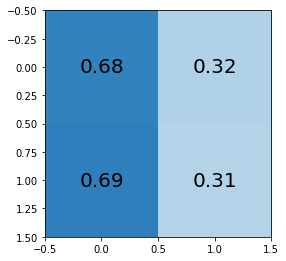

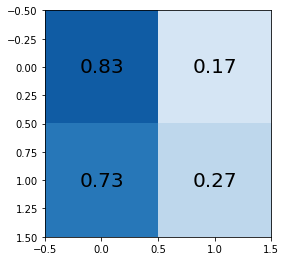

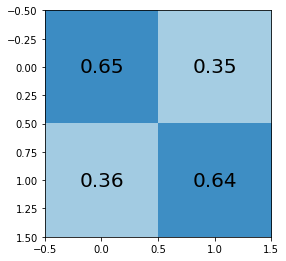

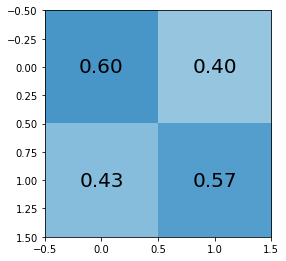

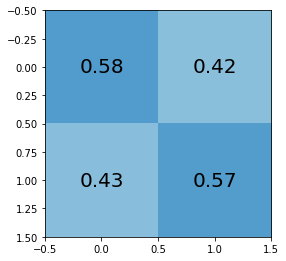

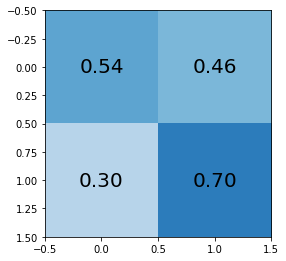

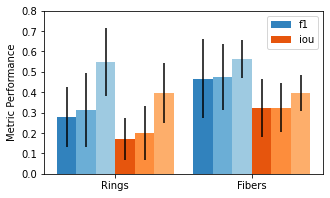

In [117]:
# labels = ["Precise", "UNet", "MaskRCNN", "ilastik"]
# fig = plot_scores(score_dicts, ["Precise", "UNet", "MaskRCNN", "ilastik"], score_keys)
# fig.savefig("./panels/scores.pdf", bbox_inches="tight", transparent=True)
# all_tables = []
# for metric in score_keys:
#     samples = [score_dicts[condition][metric][structure] \
#                   for structure in ["rings", "fibers"] \
#                   for condition in ["Precise", "UNet", "MaskRCNN", "ilastik"]]
#     tmp = ["{} - {}".format(structure, condition) \
#                 for structure in ["rings", "fibers"] \
#                 for condition in ["MICRA-Net", "U-Net", "Mask R-CNN", "ilastik"]]
# #     sig = statistics.get_significance(samples, force_normal_test=True, verbose=True)
#     p_values, f_p_values = resampling_stats(samples, tmp, show_ci=False)
#     print(metric)
#     print(f_p_values)
#     table = create_latex_table(p_values, samples, tmp)
#     all_tables.append(metric)
#     all_tables.append("{:0.4e}".format(f_p_values))
#     all_tables.append(table)
# pyplot.show()

# fig = plot_fft(list(fft_dicts[_key]["rings"] for _key in ["Precise", "UNet", "MaskRCNN", "ilastik"]), ["Precise", "UNet", "MaskRCNN", "ilastik"])
# fig.savefig("./panels/rings_fft.pdf", bbox_inches="tight", transparent=True)
# samples = list(fft_dicts[_key]["rings"] for _key in ["Precise", "UNet", "MaskRCNN", "ilastik"])
# p_values, f_p_values = resampling_stats(samples, labels, show_ci=False)
# print("FFT metric")
# print(f_p_values)
# table = create_latex_table(p_values, samples, ["MICRA-Net", "U-Net", "Mask R-CNN", "ilastik"])
# all_tables.append("FFT")
# all_tables.append(table)
# # statistics.get_significance(samples, force_normal_test=True, verbose=True)
# pyplot.show()

# figs, tables = plot_hist(list(dist_dicts[_key] for _key in ["Precise", "UNet", "MaskRCNN", "ilastik"]), ["Precise", "UNet", "MaskRCNN", "ilastik"],
#                     comparison=[dist_dicts["Expert"], "Expert"], cumfreq=False)
# all_tables.extend(tables)

# with open("../../table_actin_score.tex", "w") as f:
#     f.write("\n".join(all_tables))
    
# for fig, name in zip(figs, ["MICRA-Net", "U-Net", "Mask R-CNN", "ilastik"]):
#     fig.savefig("./panels/dist_expert_{}.pdf".format(name), bbox_inches="tight", transparent=True)

samples = ["MICRA-Net", "MICRA-Net-SSL", "UNet"]
figs = plot_cm(list(cm_dicts[_key]["rings"] for _key in samples), samples)
figs = plot_cm(list(cm_dicts[_key]["fibers"] for _key in samples), samples)

figs = plot_scores(score_dicts, samples, metrics=["f1", "iou"])

pyplot.show()

# Compare : precise vs. user-study

(3, 25, 68)
['Expert', 'Precise', 'User-Study']


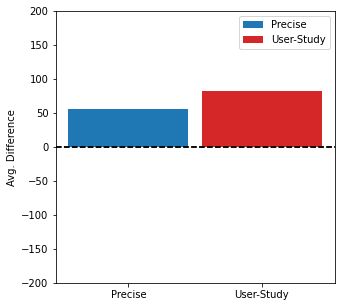

In [ ]:
import dill
path = "/home-local/Multilabel-Proteins-Actin/Segmentation/User-Study"
userstudy = dill.load(open(os.path.join(path, "data.pkl"), "rb"))

# Scores
temp = {metric : {structure : [] for structure in ["rings", "fibers"]} for metric in score_keys}
for metric in score_keys:
    for structure in ["rings", "fibers"]:
        temp[metric][structure].extend([numpy.mean(userstudy[key][structure][metric]) for key in userstudy.keys()])
score_dicts["User-Study"] = temp

# fig = plot_scores(score_dicts, ["Precise", "User-Study"], score_keys)
# # fig.savefig("./panels/score_precise_userstudy.pdf", bbox_inches="tight", transparent=True)
# pyplot.show()
# tables = []
# for metric in score_keys:
#     print(metric)
#     samples = [score_dicts[condition][metric][structure] \
#                   for structure in ["rings", "fibers"] \
#                   for condition in ["Precise", "User-Study"]]
#     labels = ["{}-{}".format(structure, condition) \
#                  for structure in ["rings", "fibers"] \
#                  for condition in ["Precise", "User-Study"]]
# #     sig = statistics.get_significance(samples, force_normal_test=True, verbose=True)
#     p_values, f_p_values = resampling_stats(samples, labels, show_ci=False)
#     table = create_latex_table(p_values, samples, formatted_labels=["MICRA-Net - rings", "User-Study - rings", "MICRA-Net - fibers", "User-Study - fibers"])
#     tables.extend([
#         metric, 
#         "{}".format(f_p_values),
#         table
#     ])
# with open("../../table_actin_user-study_score.tex", "w") as f:
#     f.write("\n".join(tables))
    
# # FFT bootstrap
# # temp = {structure : [] for structure in ["rings", "fibers"]}
# # for structure in ["rings", "fibers"]:
# #     temp[structure].extend([numpy.mean(userstudy[key][structure]["fft"]) for key in userstudy.keys()])
# # fft_dicts["User-Study"] = temp
# # plot_fft_bootstrap(list(fft_dicts[_key]["rings"] for _key in ["Precise", "User-Study"]), ["Precise", "User-Study"])

# # FFT
temp = {structure : [] for structure in ["rings", "fibers"]}
for structure in ["rings", "fibers"]:
    temp[structure].extend([userstudy[key][structure]["fft"] for key in userstudy.keys()])
fft_dicts["User-Study"] = {structure : numpy.mean(temp[structure], axis=0).tolist() for structure in ["rings", "fibers"]}
# fig = plot_fft(list(fft_dicts[_key]["rings"] for _key in ["Precise", "User-Study"]), ["Precise", "User-Study"])
# # fig.savefig("/home/anthony/Desktop/fft_precise_userstudy.pdf", bbox_inches="tight", transparent=True)
# samples = list(fft_dicts[_key]["rings"] for _key in ["Precise", "User-Study"])
# # statistics.get_significance(samples, force_normal_test=True, verbose=True)
# pvalues, F_p_values = resampling_stats(samples, labels=["Precise", "User-Study"], show_ci=False)
# table = create_latex_table(pvalues, samples, formatted_labels=["MICRA-Net", "User-Study"])
# with open("../../table_actin_user-study_fft.tex", "w") as f:
#     f.write(table)
# # fig.savefig("./panels/metric_fft_userstudy.pdf", bbox_inches="tight", transparent=True)
# pyplot.show()

# # Distributions
temp = {structure : [] for structure in ["rings", "fibers"]}
for structure in ["rings", "fibers"]:
    temp[structure].extend(numpy.mean([userstudy[key][structure]["dist"] for key in userstudy.keys()], axis=0))
dist_dicts["User-Study"] = temp
# fig = plot_hist(list(dist_dicts[_key] for _key in ["Expert", "Precise", "User-Study"]), ["Expert", "Precise", "User-Study"])
fig, tables = plot_hist_diff(
    list(dist_dicts[_key] for _key in ["Precise", "User-Study"]), 
    ["Precise", "User-Study"],
    comparison=[dist_dicts["Expert"], "Expert"], 
    cumfreq=False, 
#     xlim=(0, 70)
    ylim=(-200, 200), 
    ylabel="Avg. Difference", 
    xticks=numpy.arange(2), xticklabels=["Precise", "User-Study"],
    xlabel=None
)
# fig, tables = plot_hist(
#     list(dist_dicts[_key] for _key in ["Precise", "UNet", "MaskRCNN", "ilastik", "User-Study"]), 
#     ["Precise", "UNet", "MaskRCNN", "ilastik", "User-Study"],
#     comparison=[dist_dicts["Expert"], "Expert"],
# #     xlim=(0, 70)
# )
fig.savefig("./panels/metric_avg_dist_userstudy_complete.pdf", bbox_inches="tight", transparent=True)
# with open("../../table_actin_user-study_dist.tex", "w") as f:
#     f.write("\n".join(tables))
# fig.savefig("/home/anthony/Desktop/dist_precise_userstudy.pdf", bbox_inches="tight", transparent=True)
# for fig, name in zip(figs, ["Precise", "User-Study"]):
#     fig.savefig("/home/anthony/Desktop/dist_expert_{}.pdf".format(name), bbox_inches="tight", transparent=True)

pyplot.show()

## interexpert analysis


In [ ]:
import dill
path = "/home-local/Multilabel-Proteins-Actin/Segmentation/User-Study"
userstudy = dill.load(open(os.path.join(path, "interexpert.pkl"), "rb"))

In [ ]:
key_order = []

score_keys = ["f1", "iou", "sbd"]
fft_keys = ['Images_Andreanne', 'Images_flavie', 'Images_Mado', 'Images_paul', 'Images_Renaud', 'Images_theresa']
dist_keys = ['Images_Andreanne', 'Images_flavie', 'Images_Mado', 'Images_paul', 'Images_Renaud', 'Images_theresa']

tmp_scores = {_key : {key : {_class : [] for _class in userstudy.keys()} for key in score_keys} for _key in fft_keys}

for key, values in userstudy.items():
    images = numpy.array([values[user] for user in fft_keys])
    
    for gt_id in range(len(fft_keys)):
        other_ids = list(range(len(fft_keys)))
        other_ids.pop(gt_id)
        
        for other_id, _mask in zip(other_ids, images[other_ids, 0, :, :]):
            tmp_scores[fft_keys[gt_id]]["f1"][key].append(f1_score(confusion_matrix(images[gt_id, 0, :, :], _mask, images[gt_id, 1, :, :])))
            tmp_scores[fft_keys[gt_id]]["iou"][key].append(iou_score(images[gt_id, 0, :, :], _mask, images[gt_id, 1, :, :]))
            tmp_scores[fft_keys[gt_id]]["sbd"][key].append(SBD(images[gt_id, 0, :, :], _mask, foreground=images[gt_id, 1, :, :]))

#     for _key, _mask in zip(fft_keys, (coarse, precise, unet)):
#         score_dicts[_key]["f1"][key].append(f1_score(confusion_matrix(mask_precise, _mask, dendrite)))
#         score_dicts[_key]["iou"][key].append(iou_score(mask_precise, _mask, dendrite))
#         score_dicts[_key]["sbd"][key].append(SBD(mask_precise, _mask, foreground=dendrite))

/home/anthony/Documents/Multilabel-Proteins/Actin-UNet/figure/fig.py:68: RuntimeWarning: invalid value encountered in long_scalars
  return (2 * cm[1, 1]) / (cm[0, 1] + 2 * cm[1, 1] + cm[1, 0])
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


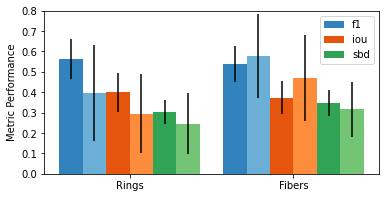

f1
The standardize residuals are normaly distributed.
The null hypothesis can be rejected from the ANOVA one way test.
	pvalue : 0.0010107981891700236
Posthoc ttest is computed on the data
Posthoc t-test results
	pvalues :           1         2         3         4
1  1.000000  0.002069  0.332854  0.787044
2  0.002069  1.000000  0.007375  0.006485
3  0.332854  0.007375  1.000000  0.400219
4  0.787044  0.006485  0.400219  1.000000
iou
The standardize residuals are normaly distributed.
The null hypothesis can be rejected from the ANOVA one way test.
	pvalue : 0.0020473563669846143
Posthoc ttest is computed on the data
Posthoc t-test results
	pvalues :           1         2         3         4
1  1.000000  0.019858  0.295969  0.137766
2  0.019858  1.000000  0.070157  0.003910
3  0.295969  0.070157  1.000000  0.038614
4  0.137766  0.003910  0.038614  1.000000
sbd
The standardize residuals are normaly distributed.
The null hypothesis can be rejected from the ANOVA one way test.
	pvalue : 0.0

In [ ]:
user_keys = ['Images_Andreanne', 'Images_flavie', 'Images_Mado', 'Images_paul', 'Images_Renaud', 'Images_theresa']
output = {s : {key : [] for key in keys} for s  in score_keys}
for metric in score_keys:
    for image_id in userstudy.keys():
        total_scores = [tmp_scores[user][metric][image_id] for user in user_keys]
        total_scores = numpy.array(total_scores)
        total_scores = numpy.nan_to_num(total_scores)

        output[metric][image_id.split("_")[0]].append(numpy.mean(total_scores))

score_dicts["interuser"] = output
fig = plot_scores(score_dicts, ["Precise", "interuser"], score_keys)
pyplot.show()

for metric in score_keys:
    samples = [score_dicts[condition][metric][structure] \
                  for structure in ["rings", "fibers"] \
                  for condition in ["Precise", "interuser"]]
    print(metric)
    sig = statistics.get_significance(samples, force_normal_test=True, verbose=True)

## Compare smaller crops and bigger crops 


In [ ]:
tmp_dicts = score_dicts.copy()
tmp_dicts.update(sc_score_dicts)

fig = plot_scores(tmp_dicts, ["Precise", "128px", "64px"], score_keys)
# fig.savefig("/home/anthony/Desktop/score_precise_coarse.pdf", bbox_inches="tight", transparent=True)
for metric in score_keys:
    samples = [tmp_dicts[condition][metric][structure] \
                  for structure in ["rings", "fibers"] \
                  for condition in ["Precise", "128px", "64px"]]
    print(metric)
    sig = statistics.get_significance(samples, force_normal_test=True, verbose=True)

tmp_dicts = fft_dicts.copy()
tmp_dicts.update(sc_fft_dicts)
fig = plot_fft(list(tmp_dicts[_key]["rings"] for _key in ["Precise", "128px", "64px"]), ["Precise", "128px", "64px"])
# fig.savefig("/home/anthony/Desktop/fft_precise_coarse.pdf", bbox_inches="tight", transparent=True)
samples = list(tmp_dicts[_key]["rings"] for _key in ["Precise", "128px", "64px"])
statistics.get_significance(samples, force_normal_test=True, verbose=True)

tmp_dicts = dist_dicts.copy()
tmp_dicts.update(sc_dist_dicts)
figs = plot_hist(list(tmp_dicts[_key] for _key in ["Precise"]), ["Precise"],
                   comparison=[tmp_dicts["Expert"], "Expert"])
figs = plot_hist(list(tmp_dicts[_key] for _key in ["128px"]), ["128px"],
                   comparison=[tmp_dicts["Expert"], "Expert"])
figs = plot_hist(list(tmp_dicts[_key] for _key in ["64px"]), ["64px"],
                   comparison=[dist_dicts["Expert"], "Expert"])
# for fig, name in zip(figs, ["Coarse", "Precise"]):
#     fig.savefig("/home/anthony/Desktop/dist_expert_{}.pdf".format(name), bbox_inches="tight", transparent=True)

# figs = plot_cm(list(cm_dicts[_key]["rings"] for _key in ["Precise", "Coarse"]), ["Precise", "Coarse"])
# for fig, name in zip(figs, ["Precise", "Coarse"]):
#     fig.savefig(f"/home/anthony/Desktop/cm_rings_{name}.pdf", bbox_inches="tight", transparent=True)
# figs = plot_cm(list(cm_dicts[_key]["fibers"] for _key in ["Precise", "Coarse"]), ["Precise", "Coarse"])
# for fig, name in zip(figs, ["Precise", "Coarse"]):
#     fig.savefig(f"/home/anthony/Desktop/cm_fibers_{name}.pdf", bbox_inches="tight", transparent=True)
# pyplot.show()

# Classification from UNet 

In [ ]:
import dill
path = "/home-local/Multilabel-Proteins-Actin/Segmentation/User-Study"
userstudy = dill.load(open(os.path.join(path, "data.pkl"), "rb"))
print(userstudy["Images_Andreanne"]["fibers"])

# Cumming FFT 

In [ ]:
def fft_ratio(image, predicted, foreground):
    """
    Computes the cross correlation between the pixels in the ground truth mask
    and the pixels in the predicted mask

    :param image: A 2D `numpy.ndarray` of the image
    :param truth: A 2D `numpy.ndarray` of the ground truth mask
    :param predicted: A 2D `numpy.ndarray` of the predicted mask
    :param foreground: A 2D `numpy.ndarray` of the detected foreground

    :returns : The cross correlation after shuffle
    """
    predicted, foreground = map(lambda ary : ary.astype(bool), (predicted, foreground))
    ary_2 = image * predicted * foreground

    fft_orig, freq = fft(image, numpy.ones(image.shape))
    fft_pred, freq = fft(ary_2.reshape(image.shape), numpy.ones(image.shape))

    # Creates a mesh grid of angles
    yy, xx = numpy.meshgrid(*freq)
    xx[(xx == 0)] += 1 # Avoids 0 division
    atan = numpy.arctan(yy / xx) * 180 / numpy.pi + 90
    atan[xx >= 0] += 180

    forig, fpred = [], []
    angles, wavelengths = numpy.arange(0, 360, 10), numpy.arange(170, 200, 10)
    for angle in angles:
        for wavelength in wavelengths:
            z = (xx**2 + yy**2 <= (1 / wavelength)**2) & (xx**2 + yy**2 >= (1 / (wavelength + 10))**2) & \
                (atan >= angle) & (atan <= angle + 10)
            forig.append(fft_orig[z].sum())
            fpred.append(fft_pred[z].sum())

    forig, fpred = map(lambda l : numpy.array(l).reshape(len(angles), len(wavelengths)), (forig, fpred))
    ratio_pred = (fpred.sum() - forig.sum()) / fft_orig.sum()
    return ratio_pred


In [ ]:
# Get data
score_keys = ["f1", "iou", "sbd"]
fft_keys = ["Expert", "Coarse", "Precise", "UNet", "MaskRCNN", "ilastik"]
dist_keys = ["Expert", "Coarse", "Precise", "UNet", "MaskRCNN", "ilastik"]

score_dicts = {_key : {key : {_class : [] for _class in keys} for key in score_keys} for _key in fft_keys}
dist_dicts = {key : {_class : [] for _class in keys} for key in dist_keys}
fft_dicts = {key : {_class : [] for _class in keys} for key in fft_keys}
cm_dicts = {key : {_class : [] for _class in keys} for key in fft_keys}
prediction_dicts = {key : [] for key in fft_keys}

for key, values in tqdm(files.items(), desc="Conditions"):
    for filename in tqdm(values, desc="Images", leave=False):
        num, channel = int(filename.split(os.path.sep)[-1].split("_")[-1].split("-")[0]),\
                       int(filename.split(os.path.sep)[-1].split("_")[-1].split("-")[-1].split(".")[0])

        coarse = io.imread(os.path.join(image_folder, "{}_coarse.tif".format(num)))[channel, 0 if key == "rings" else 1, : ,:]
        precise = io.imread(os.path.join(image_folder, "{}_precise.tif".format(num)))[channel, 0 if key == "rings" else 1, : ,:]
        unet = io.imread(os.path.join(image_folder, "{}_unet.tif".format(num)))[channel, 0 if key == "rings" else 1, : ,:]
        maskrcnn = io.imread(os.path.join(image_folder, "20201227-093229", "{}_image.tif_prediction.tif".format(num)))[channel, 0 if key == "rings" else 1, : ,:]

        with h5py.File("/home-local/Multilabel-Proteins-Actin/ilastik/testing-{}_image.tif-image-prediction.h5".format(num), "r") as ilastik_file:
            ilastik = ilastik_file["exported_data"][channel].squeeze()
            ilastik = (ilastik == 2).astype(int) if key == "rings" else (ilastik == 3).astype(int)
        
        mask_precise = io.imread(filename)[:, :, 3]
        mask = io.imread(os.path.join(image_folder, "{}_mask.tif".format(num)))[channel, 0 if key == "rings" else 1, : ,:]
        dendrite = io.imread(os.path.join(image_folder, "{}_dendrite.tif".format(num)))[channel]
        image = io.imread(os.path.join(image_folder, "{}_image.tif".format(num)))[channel, :, :]

        for _key, _mask in zip(fft_keys, (mask_precise, coarse, precise, unet, maskrcnn, ilastik)):
            fft_dicts[_key][key].append(fft_ratio(image, _mask, dendrite))


\begin{tabular}{cccccc}
\toprule
{} &                                              Expert &                                           MICRA-Net &                                               U-Net &                                          Mask R-CNN &                                             Ilastik \\
\midrule
Expert     &                                                   - &                                   \SI{6.4470e-01}{} &  \textcolor[rgb]{0.93,0.26,0.18}{\SI{2.4000e-03}{}} &  \textcolor[rgb]{0.39,0.68,0.75}{\SI{4.8000e-03}{}} &  \textcolor[rgb]{0.39,0.68,0.75}{<\SI{1.0000e-4}{}} \\
MICRA-Net  &                                   \SI{6.4470e-01}{} &                                                   - &  \textcolor[rgb]{0.93,0.26,0.18}{\SI{1.0500e-02}{}} &  \textcolor[rgb]{0.39,0.68,0.75}{\SI{4.3000e-03}{}} &  \textcolor[rgb]{0.39,0.68,0.75}{<\SI{1.0000e-4}{}} \\
U-Net      &  \textcolor[rgb]{0.39,0.68,0.75}{\SI{2.4000e-03}{}} &  \textcolor[rgb]{0.39,0.68,0.75}{\SI{1.0500e-02

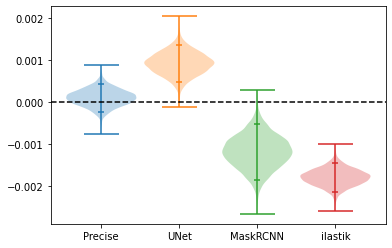

\begin{tabular}{cccc}
\toprule
{} &                                              Expert &                                           MICRA-Net &                                          User-Study \\
\midrule
Expert     &                                                   - &                                   \SI{6.4310e-01}{} &  \textcolor[rgb]{0.93,0.26,0.18}{<\SI{1.0000e-4}{}} \\
MICRA-Net  &                                   \SI{6.4310e-01}{} &                                                   - &  \textcolor[rgb]{0.93,0.26,0.18}{<\SI{1.0000e-4}{}} \\
User-Study &  \textcolor[rgb]{0.39,0.68,0.75}{<\SI{1.0000e-4}{}} &  \textcolor[rgb]{0.39,0.68,0.75}{<\SI{1.0000e-4}{}} &                                                   - \\
\bottomrule
\end{tabular}



In [ ]:
import matplotlib

def bootstrap(values, reps=10000):
    choices = numpy.random.choice(len(values), size=(10000, len(values)), replace=True)
    values = numpy.mean(values[choices], axis=1)
    return values

def cumming_plot(ctrl, samples, labels=None):
    
    if isinstance(ctrl, (list, tuple)):
        ctrl = numpy.array(ctrl)
    if isinstance(samples, (list, tuple)):
        samples = numpy.array(samples, dtype="object")
    
    bstrap_ctrl = bootstrap(ctrl)
    
    fig, ax = pyplot.subplots()
    data = []
    for i, sample in enumerate(samples): 
        diff = bootstrap(sample) - bstrap_ctrl
        ax.violinplot(diff.astype(float), positions=[i], widths=0.9)
        ax.scatter([i, i], numpy.quantile(diff, [0.05, 0.95]), marker="_")
    ax.axhline(y=0, color="black", linestyle="dashed")
    
    if isinstance(labels, (list, tuple)):
        ax.set(
            xticks=numpy.arange(len(labels)), xticklabels=labels
        )
    
    return fig, ax

labels = ["Precise", "UNet", "MaskRCNN", "ilastik"]
ctrl = fft_dicts["Expert"]["rings"]
samples = [fft_dicts[key]["rings"] for key in labels]
fig, ax = cumming_plot(ctrl, samples, labels=labels)

labels = ["Expert"] + labels
samples = [fft_dicts[key]["rings"] for key in labels]

p_values, F_p_values = resampling_stats(samples, labels, show_ci=False)
table = create_latex_table(p_values, samples, ["Expert", "MICRA-Net", "U-Net", "Mask R-CNN", "Ilastik"])
print(table)
pyplot.show()

labels = ["Expert", "Precise", "User-Study"]
samples = [fft_dicts[key]["rings"] for key in labels]
p_values, F_p_values = resampling_stats(samples, labels, show_ci=False)
table = create_latex_table(p_values, samples, ["Expert", "MICRA-Net", "User-Study"])
print(table)